# London - Milestone Project
This project is based on a Kaggle dataset:
https://www.kaggle.com/edenau/london-bike-sharing-system-data

You actually have to retrieve to CSV files there **yourselves**!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import time
import math
import statistics

In [36]:
# This won't work for you - at least not directly!
df_stations = pd.read_csv("Data/bike_sharing/stations.csv", index_col="Station ID")
df_journeys = pd.read_csv("Data/bike_sharing/journeys.csv")

#### London Coordinates
51.5074° N, 0.1278° W

Make sure to correctly convert **N** and **W** when using with a map.

### 1a) Plot Journey Durations
In your journey data, you have the journey duration for all trips. Play around with the plotting tools we talked about - do **journey durations depend on the time of day?**

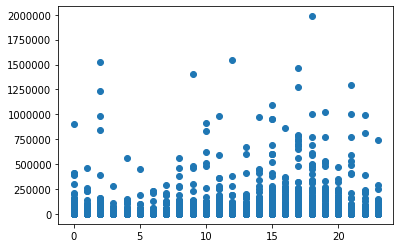

In [4]:
plt.scatter(x="Start Hour", y="Journey Duration", data=df_journeys)

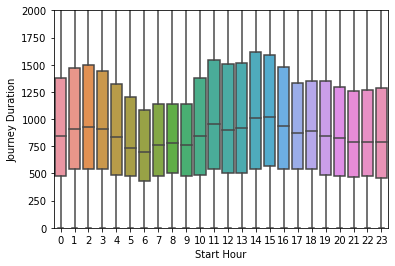

In [15]:
ax = sns.boxplot(x="Start Hour", y="Journey Duration", data=df_journeys)
ax.set(ylim=(0, 2000))
plt.show()

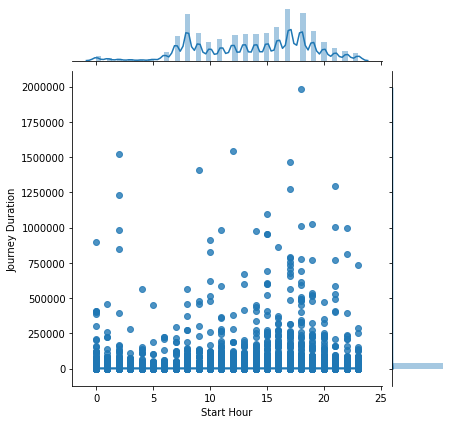

In [6]:
sns.jointplot(x="Start Hour", y="Journey Duration", data=df_journeys, kind="reg")
plt.show()

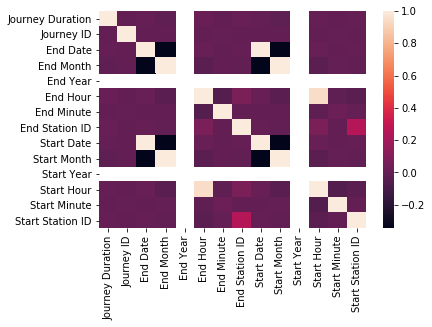

In [37]:
sns.heatmap(df_journeys.corr())

### 1b) Predict Journey Durations
You have lot's of information for the trip. Use just the data that is known at the beginning of the trip (i.e., start time and start station) to predict the journy duration. Use any regression model your a comfortable with.

#### Own function

#### data preparation

In [2]:
# Load dataset
df_journeys = pd.read_csv("Data/bike_sharing/journeys.csv")
df_journeys.drop("Journey ID", axis=1, inplace=True)
# set scaler
st_scaler = StandardScaler()
# divide dataset
train_set = df_journeys.sample(frac=0.75, random_state=0)
test_set = df_journeys.drop(train_set.index)

In [16]:
# subset selection and data preparation
sample_fraction = 0.01 #This declares the random fraction of the dataset used 
train_set_sample = train_set.sample(frac=sample_fraction)
test_set_sample = test_set.sample(frac=sample_fraction)
X_train = train_set_sample[train_set_sample.columns.difference(['Journey Duration', 'End Station ID', 'Start Station ID'])]
y_train = train_set_sample["Journey Duration"]
X_test = test_set_sample[test_set_sample.columns.difference(['Journey Duration', 'End Station ID', 'Start Station ID'])]
y_test = test_set_sample["Journey Duration"]
st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)
X_test_scaled = st_scaler.transform(X_test)

In [17]:
# PCA: reduces variables from 10 to 5
pca = PCA(n_components=5)
pca.fit(X_train_scaled)
X_train_transformed = pca.transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)
print(pca.explained_variance_ratio_)

[0.3363061  0.24368592 0.16375649 0.12499264 0.1247376 ]


#### Mean Model

In [11]:
# confidence interval
mean_model_mean = y_test.mean()
confidence_interval = pd.DataFrame(abs(y_test-mean_model_mean))
stats = confidence_interval.agg(['mean', 'count', 'std'])
ci95_hi = (stats.loc['mean'] + 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
ci95_lo = (stats.loc['mean'] - 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
# print
print("MAE: ", stats.loc['mean'].values[0],", 95% confidence interval: [", ci95_lo,"; ", ci95_hi,"]")
# for the summary of predictions below
if 'MAE_summary' in globals():
    del(MAE_summary)
MAE_metrics = [[stats.loc['mean'].values[0], ci95_lo, ci95_hi]]
MAE_summary = pd.DataFrame(data= MAE_metrics, index = ["Mean Model"], columns = ["MAE", "CI low", "CI high"])

MAE:  954.6818463623433 , 95% confidence interval: [ 935.1795457602069 ;  974.1841469644797 ]


#### OLS regression

In [12]:
# without PCA
lin = LinearRegression()
lin.fit(X_train_scaled, y_train)
y_predictions = lin.predict(X_test_scaled)
# confidence interval
confidence_interval = pd.DataFrame(abs(y_test-y_predictions))
stats = confidence_interval.agg(['mean', 'count', 'std'])
ci95_hi = (stats.loc['mean'] + 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
ci95_lo = (stats.loc['mean'] - 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
# print
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predictions),", 95% confidence interval: [", ci95_lo,"; ", ci95_hi,"]")
# for the summary of predictions below
row_df = pd.DataFrame([[metrics.mean_absolute_error(y_test, y_predictions), ci95_lo, ci95_hi]], index = ["OLS with PCA"], columns = ["MAE", "CI low", "CI high"])
MAE_summary = pd.concat([row_df, MAE_summary])

RMSE:  18.955653062156006
MAE:  12.013365803887796 , 95% confidence interval: [ 11.967091421042573 ;  12.059640186733018 ]


In [13]:
# with PCA
lin = LinearRegression()
lin.fit(X_train_transformed, y_train)
y_predictions = lin.predict(X_test_transformed)
# confidence interval
confidence_interval = pd.DataFrame(abs(y_test-y_predictions))
stats = confidence_interval.agg(['mean', 'count', 'std'])
ci95_hi = (stats.loc['mean'] + 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
ci95_lo = (stats.loc['mean'] - 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
# print
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predictions),", 95% confidence interval: [", ci95_lo,"; ", ci95_hi,"]")
# for the summary of predictions below
row_df = pd.DataFrame([[metrics.mean_absolute_error(y_test, y_predictions), ci95_lo, ci95_hi]], index = ["OLS"], columns = ["MAE", "CI low", "CI high"])
MAE_summary = pd.concat([row_df, MAE_summary])

RMSE:  6251.506871103872
MAE:  948.5177454494647 , 95% confidence interval: [ 929.0169206298395 ;  968.0185702690898 ]


#### KNN

# hyperparameter optimization
start_time = time.time()
counter = 1
best_leaf = []
best_p = []
best_n = []
while(counter>0):
    print(counter)
    # subset selection and data preparation
    sample_fraction = 0.1
    train_set_sample = train_set.sample(frac=sample_fraction)
    test_set_sample = test_set.sample(frac=sample_fraction)
    X_train = train_set_sample[train_set_sample.columns.difference(['Journey Duration', 'End Station ID', 'Start Station ID'])]
    y_train = train_set_sample["Journey Duration"]
    X_test = test_set_sample[test_set_sample.columns.difference(['Journey Duration', 'End Station ID', 'Start Station ID'])]
    y_test = test_set_sample["Journey Duration"]
    st_scaler.fit(X_train)
    X_train_scaled = st_scaler.transform(X_train)
    X_test_scaled = st_scaler.transform(X_test)
    X_train_transformed = pca.transform(X_train_scaled)
    X_test_transformed = pca.transform(X_test_scaled)
    # Randomized search
    leaf_size = list(range(10,85))
    n_neighbors = list(range(2,5))
    p=[2]
    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
    knn = KNeighborsRegressor()
    clf = RandomizedSearchCV(knn, hyperparameters, cv=5, scoring='neg_mean_absolute_error', n_iter=100)
    best_model = clf.fit(X_train_transformed, y_train)
    counter -= 1
    best_leaf.append(best_model.best_estimator_.get_params()['leaf_size'])
    best_p.append(best_model.best_estimator_.get_params()['p'])
    best_n.append(best_model.best_estimator_.get_params()['n_neighbors'])
print('Best leaf_size:', min(best_leaf), max(best_leaf), statistics.median(best_leaf))
print('Best p:', min(best_p), max(best_p), statistics.median(best_p))
print('Best n_neighbors:', min(best_p), max(best_n), statistics.median(best_p))
end_time = time.time()
print("time lapsed", end_time - start_time)
print("Warning by the author: You have to reset the sample fraction in the data preparation")

In [14]:
# actual model application
start_time = time.time()
knn = KNeighborsRegressor(n_neighbors = 2, p = 2, leaf_size = 27)
knn.fit(X_train_transformed, y_train)
y_predictions = knn.predict(X_test_transformed)
# confidence interval
confidence_interval = pd.DataFrame(abs(y_test-y_predictions))
stats = confidence_interval.agg(['mean', 'count', 'std'])
ci95_hi = (stats.loc['mean'] + 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
ci95_lo = (stats.loc['mean'] - 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
# print
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predictions),", [", ci95_lo,"; ", ci95_hi,"]")
end_time = time.time()
print("time lapsed", end_time - start_time)
# for the summary of predictions below
row_df = pd.DataFrame([[metrics.mean_absolute_error(y_test, y_predictions), ci95_lo, ci95_hi]], index = ["KNN"], columns = ["MAE", "CI low", "CI high"])
MAE_summary = pd.concat([row_df, MAE_summary])

RMSE:  6859.974567774856
MAE:  447.06425795479 , [ 425.4607681388802 ;  468.66774777069975 ]
time lapsed 7.521975517272949


#### Random Forest

In [15]:
start_time = time.time()
rf = RandomForestRegressor()
rf.fit(X_train_transformed, y_train)
y_predictions = rf.predict(X_test_transformed)
# confidence interval
confidence_interval = pd.DataFrame(abs(y_test-y_predictions))
stats = confidence_interval.agg(['mean', 'count', 'std'])
ci95_hi = (stats.loc['mean'] + 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
ci95_lo = (stats.loc['mean'] - 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
# print
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predictions),", [", ci95_lo,"; ", ci95_hi,"]")
end_time = time.time()
print("time lapsed", end_time - start_time)
# for the summary of predictions below
row_df = pd.DataFrame([[metrics.mean_absolute_error(y_test, y_predictions), ci95_lo, ci95_hi]], index = ["Random Forest"], columns = ["MAE", "CI low", "CI high"])
MAE_summary = pd.concat([row_df, MAE_summary])

RMSE:  6187.400985610484
MAE:  338.17454987481494 , [ 318.67681100420197 ;  357.6722887454279 ]
time lapsed 1109.427444934845


#### SVM

In [18]:
start_time = time.time()
svc = SVC(kernel='linear')
svc.fit(X_train_transformed, y_train)
y_predictions = svc.predict(X_test_transformed)
# confidence interval
confidence_interval = pd.DataFrame(abs(y_test-y_predictions))
stats = confidence_interval.agg(['mean', 'count', 'std'])
ci95_hi = (stats.loc['mean'] + 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
ci95_lo = (stats.loc['mean'] - 1.96*stats.loc['std']/math.sqrt(stats.loc['count'])).values[0]
# print
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_predictions),", [", ci95_lo,"; ", ci95_hi,"]")
end_time = time.time()
print("time lapsed", end_time - start_time)
# for the summary of predictions below
row_df = pd.DataFrame([[metrics.mean_absolute_error(y_test, y_predictions), ci95_lo, ci95_hi]], index = ["SVM on 1% of the sample"], columns = ["MAE", "CI low", "CI high"])
MAE_summary = pd.concat([row_df, MAE_summary])

RMSE:  2524.4584650203005
MAE:  772.7163598651802 , [ 696.8597148607214 ;  848.5730048696389 ]
time lapsed 353.49563479423523


#### Summary of predictions

In [19]:
MAE_summary

,MAE,CI low,CI high
SVM on 1% of the sample,772.716360,696.859715,848.573005
Random Forest,338.174550,318.676811,357.672289
KNN,447.064258,425.460768,468.667748
OLS,948.517745,929.016921,968.018570
OLS with PCA,12.013366,11.967091,12.059640
Mean Model,954.681846,935.179546,974.184147


### 2a) Stations
In the "Folium" Notebook, I showed you how to create a colored map with some data. Try to create a similar map using the number of stations in the different boroughs of London (provided as GeoJson in this folder)

In [ ]:
import folium

In [ ]:
tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png'
attr="Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL."
m = folium.Map(location = [51.5074, 0.1278], zoom_start=10, tiles=tiles, attr=attr)
folium.Choropleth(
    geo_data=f"Data/boroughs.geojson").add_to(m)
m

### 2b) Coordinates
You know the stations' coordinates. Try to add two new columns to the journey DataFrame - Start Coordinate and End Coordinate

### 2c) Predict direction
Knowing the coordinate you can calculate it's distance to the city center. Create two more columns in your journey DataFrame, Start Distance and End Distance. Based on these, create another column - direction - that indicates whether the journey is inbound (i.e., towards the city center), or outbound.
Use this column as target for a binary classification. As features, use only start time and start distance!

### Extra - Revisit 1b)
Using not only the start time (and Station ID), but also the start distance, does your regression for journey durations improve?

### Extra - Plotting
We have been talking quite a bit about beatiful visualizations. Try to be creative and create some! 